In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats



In [7]:
leagues = pd.read_csv("datasets/leagues.csv")
games = pd.read_csv("datasets/games.csv")
players = pd.read_csv("players.csv")

In [24]:
print_separator("ANÁLISE DE DIAMANTES BRUTOS DO FUTEBOL EUROPEU 2024/25")

# Definir as 5 maiores ligas europeias
BIG5_LEAGUES = {
    'Premier League': 'KG1L',
    'LaLiga': 'ES1', 
    'Serie A': 'IT1',
    'Bundesliga': 'L1',
    'Ligue 1': 'FR1'
}


 ANÁLISE DE DIAMANTES BRUTOS DO FUTEBOL EUROPEU 2024/25 


In [11]:
TARGET_SEASON = '24/25'
min_goal_contribuitions = 1

In [17]:
print(f" Temporada analisada: {TARGET_SEASON}")
print(f" Ligas: {', '.join(BIG5_LEAGUES.keys())}")
print(f" Critério mínimo: {min_goal_contribuitions} contribuição(ões) para gol(s)")

 Temporada analisada: 24/25
 Ligas: Premier League, LaLiga, Serie A, Bundesliga, Ligue 1
 Critério mínimo: 1 contribuição(ões) para gol(s)


In [19]:
try:
    # alimentando meu estudo
    profiles_df = pd.read_csv('datasets/player_profiles/player_profiles.csv')
    performances_df = pd.read_csv('datasets/player_performances/player_performances.csv')
    market_value_df = pd.read_csv('datasets/player_latest_market_value/player_latest_market_value.csv')
    
    print(" Dados carregados com sucesso!")
    print(f"Perfis de jogadores: {len(profiles_df):,} registros")
    print(f"Performances: {len(performances_df):,} registros")
    print(f"Valores de mercado: {len(market_value_df):,} registros")
    
except FileNotFoundError as e:
    print(f"Erro ao carregar arquivos: {e}")
    exit(1)

print(f"\nEstrutura dos dados originais:")
print(f"Performances - Colunas principais: {list(performances_df.columns[:10])}")
print(f"Perfis - Colunas principais: {list(profiles_df.columns[:10])}")
print(f"Valores - Colunas: {list(market_value_df.columns)}")


C:\Users\vinia\AppData\Local\Temp\ipykernel_4952\2485518637.py:3: DtypeWarning: Columns (31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  profiles_df = pd.read_csv('datasets/player_profiles/player_profiles.csv')


 Dados carregados com sucesso!
Perfis de jogadores: 40,738 registros
Performances: 760,125 registros
Valores de mercado: 31,026 registros

Estrutura dos dados originais:
Performances - Colunas principais: ['player_id', 'season_name', 'competition_id', 'competition_name', 'team_id', 'team_name', 'nb_in_group', 'nb_on_pitch', 'goals', 'assists']
Perfis - Colunas principais: ['player_id', 'player_slug', 'player_name', 'player_image_url', 'name_in_home_country', 'date_of_birth', 'place_of_birth', 'country_of_birth', 'height', 'citizenship']
Valores - Colunas: ['player_id', 'date_unix', 'value']


### trabalhar filtros dentro da estrutura dos dados

In [26]:
# Obter IDs das ligas
big5_ids = list(BIG5_LEAGUES.values())

print(f"Aplicando filtros:")
print(f"Temporada: {TARGET_SEASON}")
print(f"IDs das ligas: {big5_ids}")

# Contar registros antes do filtro
total_before = len(performances_df)
print(f"Registros ANTES do filtro: {total_before:,}")

# Aplicar filtros
big5_performances = performances_df[
    (performances_df['season_name'] == TARGET_SEASON) & 
    (performances_df['competition_id'].isin(big5_ids))
].copy()

# Contar registros após filtro
total_after = len(big5_performances)
reduction = total_before - total_after

print(f"Registros APÓS filtro: {total_after:,}")
print(f"Redução: {reduction:,} registros ({reduction/total_before*100:.1f}%)")

# Mostrar distribuição por liga
print(f"Distribuição por liga:")
league_distribution = big5_performances['competition_name'].value_counts()
for league, count in league_distribution.items():
    percentage = count / total_after * 100
    print(f"   {league}: {count:,} registros ({percentage:.1f}%)")

Aplicando filtros:
Temporada: 24/25
IDs das ligas: ['KG1L', 'ES1', 'IT1', 'L1', 'FR1']
Registros ANTES do filtro: 760,125
Registros APÓS filtro: 2,800
Redução: 757,325 registros (99.6%)
Distribuição por liga:
   Serie A: 812 registros (29.0%)
   LaLiga: 745 registros (26.6%)
   Ligue 1: 664 registros (23.7%)
   Bundesliga: 579 registros (20.7%)


### agrupar por jogador (gols + assits)


In [56]:
#agrupamento
print(f"\nExemplo ANTES (jogador em múltiplos jogos):")
sample_player_id = big5_performances['player_id'].iloc[0]
sample_before = big5_performances[big5_performances['player_id'] == sample_player_id]
print(sample_before[['player_id', 'team_name', 'goals', 'assists']].head(3).to_string(index=False))

#utilizando um gropby para agrupar com base nas estatíticas que eu quero
player_performance = big5_performances.groupby('player_id').agg({
    'goals': 'sum',                    
    'assists': 'sum',                  
    'minutes_played': 'sum',           
    'competition_name': 'first',       
    'team_name': 'first'              
}).reset_index() #vou dar um indíce novo para esse jogadores dentro dessa playerbase

# Vou definir uma nova variavel para me mostrar a soma dos gols + assists, assim posso calcular com base nela e o price de cada player
player_performance['goals_contributions'] = (
    player_performance['goals'] + player_performance['assists']
)

print(f"\n Jogadores únicos após agrupamento: {len(player_performance):,}")

# Mostrar exemplo após agrupamento
sample_after = player_performance[player_performance['player_id'] == sample_player_id] #pegando so os dados depois do agrupamento
print(f"\n Exemplo APÓS (mesmo jogador, dados somados):")
print(sample_after[['player_id', 'goals', 'assists', 'goals_contributions']].to_string(index=False)) #selecionando apenas os dados que me interessam

# Filtrar jogadores com pelo menos 1 contribuição para gol
players_with_contributions = player_performance[
    player_performance['goals_contributions'] >= min_goal_contribuitions
]

print(f"\nJogadores com pelo menos {min_goal_contribuitions} G+A: {len(players_with_contributions):,}")



Exemplo ANTES (jogador em múltiplos jogos):
 player_id       team_name  goals  assists
   1203026 Montpellier HSC    0.0        0

 Jogadores únicos após agrupamento: 2,669

 Exemplo APÓS (mesmo jogador, dados somados):
 player_id  goals  assists  goals_contributions
   1203026    0.0        0                  0.0

Jogadores com pelo menos 1 G+A: 1,361


In [58]:
player_performance

,player_id,goals,assists,minutes_played,competition_name,team_name,goals_contributions
0,7161,2.0,1,176.0,Bundesliga,Bayer 04 Leverkusen,3.0
1,7825,0.0,0,1035.0,Serie A,Como 1907,0.0
2,12029,0.0,0,0.0,Ligue 1,Stade Reims,0.0
3,12282,0.0,3,0.0,LaLiga,Girona FC,3.0
4,15452,0.0,0,0.0,LaLiga,Villarreal CF,0.0
...,...,...,...,...,...,...,...
2664,1361456,0.0,0,0.0,LaLiga,UD Las Palmas,0.0
2665,1363293,0.0,0,0.0,Ligue 1,Stade Reims,0.0
2666,1367276,0.0,0,0.0,LaLiga,Real Valladolid CF,0.0
2667,1384902,0.0,0,0.0,LaLiga,Rayo Vallecano,0.0


### adicionar informações dos jogadores

In [61]:
# Selecionar e renomear colunas relevantes dos perfis
profiles_clean = profiles_df[['player_id', 'player_name', 'position', 'date_of_birth', 'citizenship']].copy()
profiles_clean.rename(columns={
    'player_name': 'name',
    'citizenship': 'nationality'
}, inplace=True)

print(f"Dados disponíveis:")
print(f"Performances: {len(players_with_contributions):,} jogadores")
print(f"Perfis: {len(profiles_clean):,} jogadores")

# Juntar dados de performance com perfis dos jogadores
player_data = players_with_contributions.merge(profiles_clean, on='player_id', how='left')

# Verificar se houve perda de dados na junção
missing_profiles = player_data['name'].isna().sum()
print(f"Após junção: {len(player_data):,} jogadores")
if missing_profiles > 0:
    print(f"Jogadores sem perfil: {missing_profiles}")

# Mostrar exemplo do resultado
print(f"\n📋 Exemplo com nomes adicionados:")
sample_with_names = player_data[['name', 'position', 'goals', 'assists', 'goals_contributions']].head(3)
print(sample_with_names.to_string(index=False))

Dados disponíveis:
Performances: 1,361 jogadores
Perfis: 40,738 jogadores
Após junção: 1,361 jogadores
Jogadores sem perfil: 3

📋 Exemplo com nomes adicionados:
                name                      position  goals  assists  goals_contributions
Jonas Hofmann (7161) Midfield - Attacking Midfield    2.0        1                  3.0
 Daley Blind (12282)        Defender - Centre-Back    0.0        3                  3.0
 Jesús Navas (15956)         Defender - Right-Back    1.0        0                  1.0


### adicionar o valor de mercado dos jogadores

In [64]:
# filtrando e adicionando jogadores com valores > 0
market_value_clean = market_value_df[market_value_df['value'] > 0].copy()

print(f"Valores de mercado disponíveis: {len(market_value_clean):,} jogadores")
print(f"Valor médio: €{market_value_clean['value'].mean():,.0f}")
print(f"Valor mediano: €{market_value_clean['value'].median():,.0f}")

# Juntar com o valor de mercado usando merge
final_data = player_data.merge(
    market_value_clean[['player_id', 'value']], 
    on='player_id', 
    how='inner'
)

# renomeando para ficar mais claro
final_data.rename(columns={'value': 'market_value_eur'}, inplace=True)

print(f"Jogadores com valor de mercado: {len(final_data):,}")

# Mostrar estatísticas dos valores
print(f"\n Estatísticas dos valores de mercado:")
print(f"   Mínimo: €{final_data['market_value_eur'].min():,.0f}")
print(f"   Máximo: €{final_data['market_value_eur'].max():,.0f}")
print(f"   Média: €{final_data['market_value_eur'].mean():,.0f}")
print(f"   Mediana: €{final_data['market_value_eur'].median():,.0f}")

Valores de mercado disponíveis: 29,120 jogadores
Valor médio: €1,830,323
Valor mediano: €300,000
Jogadores com valor de mercado: 1,358

 Estatísticas dos valores de mercado:
   Mínimo: €150,000
   Máximo: €200,000,000
   Média: €12,097,975
   Mediana: €6,000,000


### vou criar mais um filtro apenas para atacante e centroavantes

In [68]:
# Definir critério para posições ofensivas
offensive_keywords = ['Forward', 'Midfielder', 'Winger', 'Attacking']
offensive_pattern = '|'.join(offensive_keywords)

# Filtrar posições ofensivas
offensive_players = final_data[
    final_data['position'].str.contains(offensive_pattern, case=False, na=False)
].copy()

print(f"Jogadores ofensivos identificados: {len(offensive_players):,}")

# Mostrar distribuição por posição
print(f"\nDistribuição por posição:")
position_counts = offensive_players['position'].value_counts().head(10)
for position, count in position_counts.items():
    percentage = count / len(offensive_players) * 100
    print(f"   {position}: {count} jogadores ({percentage:.1f}%)")

Jogadores ofensivos identificados: 555

Distribuição por posição:
   Attack - Centre-Forward: 225 jogadores (40.5%)
   Attack - Left Winger: 117 jogadores (21.1%)
   Attack - Right Winger: 116 jogadores (20.9%)
   Midfield - Attacking Midfield: 97 jogadores (17.5%)


### Fazendo um cálculo de custo-benefício com base no gol contribuition

In [73]:
print("Criando métrica: Custo por Contribuição de Gol")
print("Fórmula: Valor de Mercado (€) ÷ (Gols + Assistências)")

# Calcular custo por contribuição de gol
offensive_players['cost_per_goal_contribution'] = (
    offensive_players['market_value_eur'] / offensive_players['goals_contributions']
)

# Ordenar por melhor custo-benefício (menor custo por contribuição)
offensive_players_sorted = offensive_players.sort_values('cost_per_goal_contribution').reset_index(drop=True)

print(f"\nTOP 10 DIAMANTES (menor custo por G+A):")
print("-" * 80)

top_10 = offensive_players_sorted.head(10)
for i, (_, player) in enumerate(top_10.iterrows(), 1):
    cost_per_ga = player['cost_per_goal_contribution']
    print(f"{i:2d}. {player['name']}")
    print(f"    Clube: {player['team_name']} ({player['competition_name']})")
    print(f"    G+A: {int(player['goals_contributions'])} | Valor: €{player['market_value_eur']:,.0f}")
    print(f"    Custo por G+A: €{cost_per_ga:,.0f}")
    print()

Criando métrica: Custo por Contribuição de Gol
Fórmula: Valor de Mercado (€) ÷ (Gols + Assistências)

TOP 10 DIAMANTES (menor custo por G+A):
--------------------------------------------------------------------------------
 1. Kike García (93936)
    Clube: Deportivo Alavés (LaLiga)
    G+A: 13 | Valor: €900,000
    Custo por G+A: €69,231

 2. Dani Rodríguez (139435)
    Clube: RCD Mallorca (LaLiga)
    G+A: 11 | Valor: €800,000
    Custo por G+A: €72,727

 3. Cristhian Stuani (59323)
    Clube: Girona FC (LaLiga)
    G+A: 13 | Valor: €1,000,000
    Custo por G+A: €76,923

 4. Pedro (65278)
    Clube: SS Lazio (Serie A)
    G+A: 11 | Valor: €1,000,000
    Custo por G+A: €90,909

 5. André Ayew (45403)
    Clube: Le Havre AC (Ligue 1)
    G+A: 5 | Valor: €600,000
    Custo por G+A: €120,000

 6. Iago Aspas (72047)
    Clube: Celta de Vigo (LaLiga)
    G+A: 15 | Valor: €2,000,000
    Custo por G+A: €133,333

 7. Robinio Vaz (1131161)
    Clube: Olympique Marseille (Ligue 1)
    G+A: 1 | 

### análise estatística dos jogadores selecionados

In [78]:
# Análise por liga
league_analysis = offensive_players_sorted.groupby('competition_name').agg({
    'goals_contributions': ['count', 'mean', 'sum'],
    'market_value_eur': ['mean', 'median'],
    'cost_per_goal_contribution': ['mean', 'median']
}).round(0)

print("Estatísticas por liga:")
print(league_analysis)

# Identificar a liga com melhores oportunidades
print(f"\nAnálise de oportunidades por liga:")
league_opportunities = offensive_players_sorted.head(20)['competition_name'].value_counts()
for league, count in league_opportunities.items():
    percentage = count / 20 * 100
    print(f"   {league}: {count}/20 no top 20 ({percentage:.0f}%)")

Estatísticas por liga:
                 goals_contributions              market_value_eur             \
                               count mean     sum             mean     median   
competition_name                                                                
Bundesliga                       137  8.0  1080.0       15524818.0  6000000.0   
LaLiga                           160  7.0  1093.0       15556250.0  5000000.0   
Ligue 1                          129  8.0   969.0       12077907.0  6000000.0   
Serie A                          129  7.0   875.0       12954651.0  7000000.0   

                 cost_per_goal_contribution             
                                       mean     median  
competition_name                                        
Bundesliga                        2377513.0  1454545.0  
LaLiga                            2225177.0  1000000.0  
Ligue 1                           1805635.0  1142857.0  
Serie A                           2043016.0  1416667.0  

Análise d

### plotando alguns gráficos para melhor entendimento da análise feita

Gráfico scatter salvo: diamantes_brutos_scatter_completo.png
Gráfico ranking salvo: top_10_diamantes_brutos_completo.png


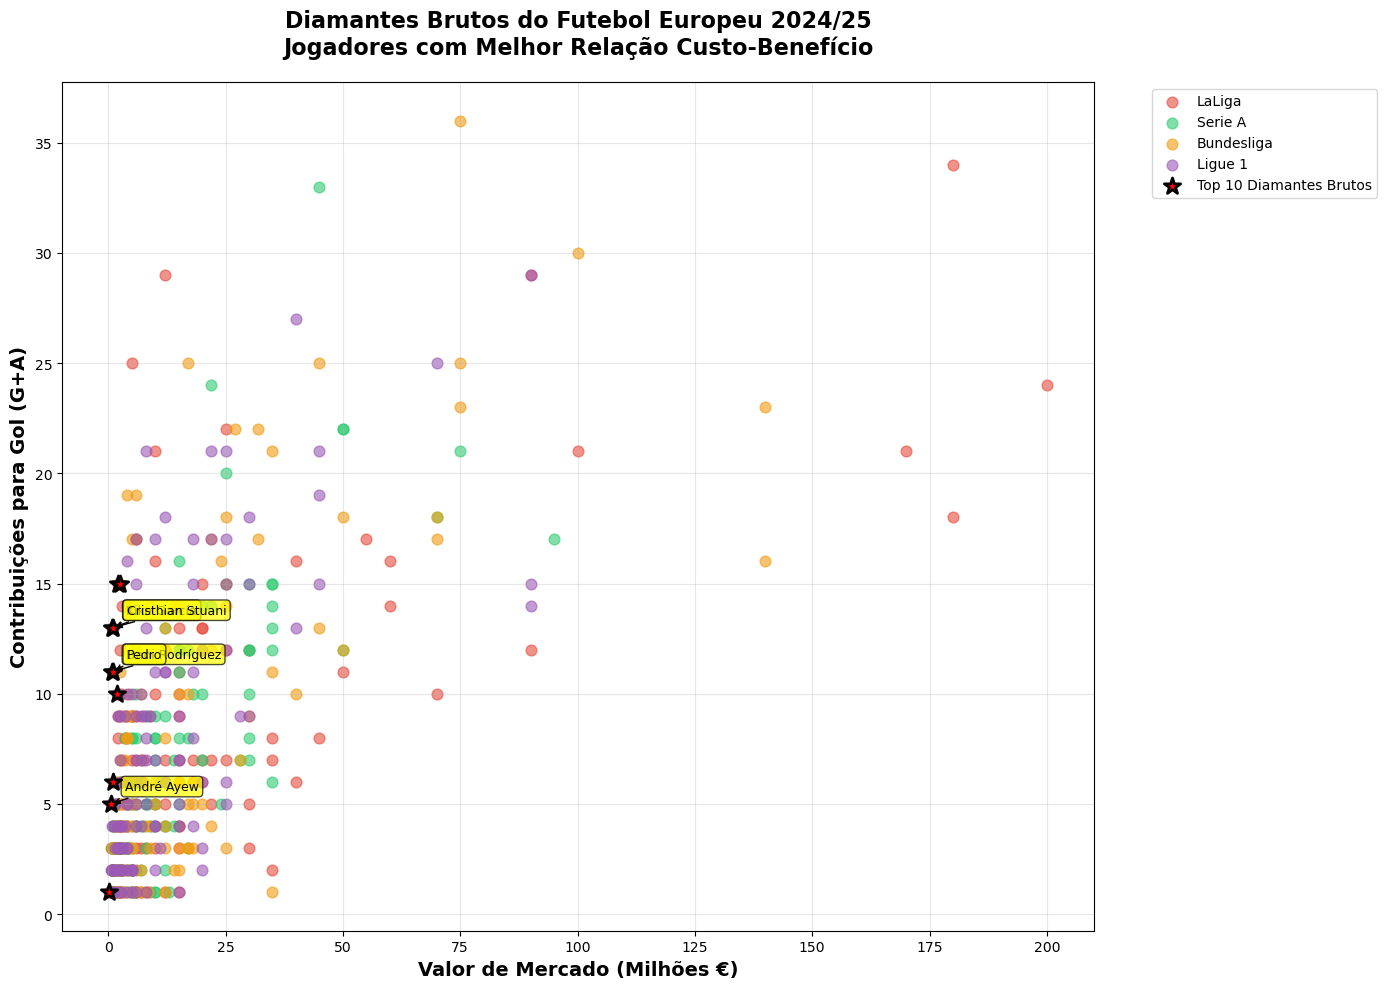

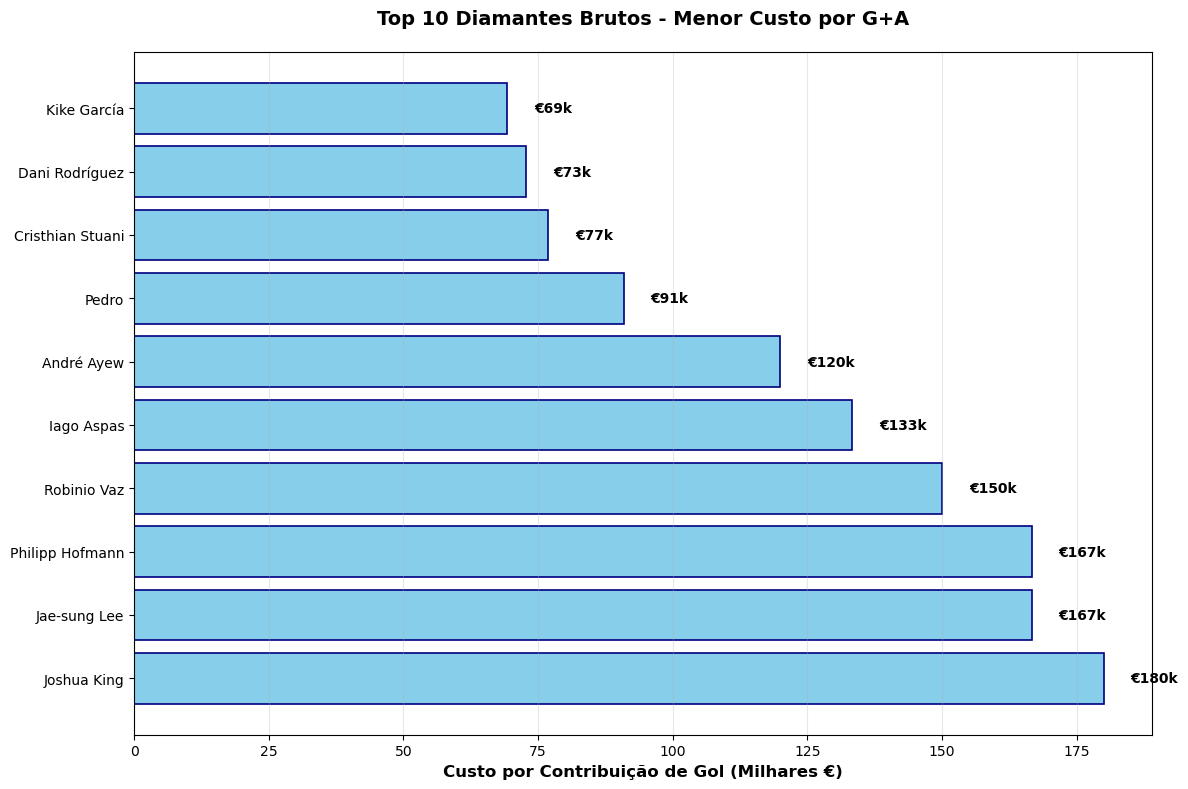

In [83]:
# Preparar dados para visualização
offensive_players_sorted['market_value_millions'] = offensive_players_sorted['market_value_eur'] / 1_000_000

# Cores por liga
league_colors = {
    'Premier League': '#3498db',  # Azul
    'LaLiga': '#e74c3c',         # Vermelho  
    'Serie A': '#2ecc71',        # Verde
    'Bundesliga': '#f39c12',     # Laranja
    'Ligue 1': '#9b59b6'         # Roxo
}

# GRÁFICO 1: Scatter Plot Principal
plt.figure(figsize=(14, 10))

# Plotar pontos por liga
for league, color in league_colors.items():
    league_data = offensive_players_sorted[offensive_players_sorted['competition_name'] == league]
    if not league_data.empty:
        plt.scatter(league_data['market_value_millions'], 
                   league_data['goals_contributions'],
                   c=color, 
                   label=league, 
                   alpha=0.6, 
                   s=60)

# Destacar top 10
top_10_viz = offensive_players_sorted.head(10)
plt.scatter(top_10_viz['market_value_millions'], 
           top_10_viz['goals_contributions'],
           c='red', 
           s=150, 
           marker='*', 
           edgecolors='black',
           linewidth=2,
           label='Top 10 Diamantes Brutos',
           zorder=5)

# Adicionar anotações para top 5
top_5 = top_10_viz.head(5)
for _, player in top_5.iterrows():
    name = player['name'].split('(')[0].strip()  # Remover ID do nome
    plt.annotate(name,
                xy=(player['market_value_millions'], player['goals_contributions']),
                xytext=(10, 10), 
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Configurar gráfico
plt.xlabel('Valor de Mercado (Milhões €)', fontsize=14, fontweight='bold')
plt.ylabel('Contribuições para Gol (G+A)', fontsize=14, fontweight='bold')
plt.title('Diamantes Brutos do Futebol Europeu 2024/25\nJogadores com Melhor Relação Custo-Benefício', 
          fontsize=16, fontweight='bold', pad=20)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig('diamantes_brutos_scatter_completo.png', dpi=300, bbox_inches='tight')
print("Gráfico scatter salvo: diamantes_brutos_scatter_completo.png")

# GRÁFICO 2: Top 10 Ranking
plt.figure(figsize=(12, 8))

# Preparar dados
top_10_chart = offensive_players_sorted.head(10).copy()
names = [name.split('(')[0].strip() for name in top_10_chart['name']]
costs = top_10_chart['cost_per_goal_contribution'] / 1000  # Converter para milhares

# Criar gráfico de barras horizontal
bars = plt.barh(range(len(names)), costs, color='skyblue', edgecolor='navy', linewidth=1.2)

# Adicionar valores nas barras
for i, (bar, cost) in enumerate(zip(bars, costs)):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             f'€{cost:.0f}k', 
             va='center', fontweight='bold', fontsize=10)

# Configurar gráfico
plt.yticks(range(len(names)), names)
plt.xlabel('Custo por Contribuição de Gol (Milhares €)', fontsize=12, fontweight='bold')
plt.title('Top 10 Diamantes Brutos - Menor Custo por G+A', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()  # Melhor no topo
plt.tight_layout()
plt.savefig('top_10_diamantes_brutos_completo.png', dpi=300, bbox_inches='tight')
print("Gráfico ranking salvo: top_10_diamantes_brutos_completo.png")